In [29]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2

from qiskit import QuantumCircuit



from qiskit.circuit.library import efficient_su2
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import RealAmplitudes

In [30]:
import numpy as np
import qubovert

In [31]:
data = np.load("sat.npz")
qubo_mat = data['qubo']
n_qubits = len(data['syms'])
print(data)
print(data['syms'])
print(qubo_mat)

NpzFile 'sat.npz' with keys: qubo, lvars, syms
['sat.$id00004.A' 'sat.$id00004.B' 'sat.$id00004.Y' 'sat.$id00003.A'
 'sat.$id00003.B' 'sat.$id00003.Y' 'sat.b' 'sat.c' 'sat.a']
[[ 4.  2. -4.  0.  0.  0.  0.  0. -8.]
 [ 0.  4. -4.  0.  0. -8.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  6.  2. -4. -8.  0.  0.]
 [ 0.  0.  0.  0.  6. -4.  0. -8.  0.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  4.]]


In [32]:
qubo = qubovert.utils.matrix_to_qubo(qubo_mat)
ising = qubovert.utils.qubo_to_quso(qubo)
qubo_dict = dict(qubo)
ising_dict = dict(ising)
print(ising_dict)
ising_dict.popitem()
print(ising_dict)
ising_mat = qubovert.utils.qubo_to_matrix(ising_dict)
print(ising_mat)

{(0,): np.float64(0.5), (0, 1): np.float64(0.5), (1,): np.float64(0.5), (0, 2): np.float64(-1.0), (2,): np.float64(1.0), (0, 8): np.float64(-2.0), (1, 2): np.float64(-1.0), (1, 5): np.float64(-2.0), (5,): np.float64(1.0), (3,): np.float64(-0.5), (3, 4): np.float64(0.5), (4,): np.float64(-0.5), (3, 5): np.float64(-1.0), (3, 6): np.float64(-2.0), (4, 5): np.float64(-1.0), (4, 7): np.float64(-2.0), (): np.float64(9.0)}
{(0,): np.float64(0.5), (0, 1): np.float64(0.5), (1,): np.float64(0.5), (0, 2): np.float64(-1.0), (2,): np.float64(1.0), (0, 8): np.float64(-2.0), (1, 2): np.float64(-1.0), (1, 5): np.float64(-2.0), (5,): np.float64(1.0), (3,): np.float64(-0.5), (3, 4): np.float64(0.5), (4,): np.float64(-0.5), (3, 5): np.float64(-1.0), (3, 6): np.float64(-2.0), (4, 5): np.float64(-1.0), (4, 7): np.float64(-2.0)}
[[ 0.5  0.5 -1.   0.   0.   0.   0.   0.  -2. ]
 [ 0.   0.5 -1.   0.   0.  -2.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.5 -1.  -2.  

In [34]:
def build_paulis(matrix):
    pauli_list = []
    for i in range(len(matrix)):
        pauli_list.append(("Z", [i], matrix[i][i]))
        for j in range(i+1, len(matrix)):
            pauli_list.append(("ZZ", [i, j], matrix[i][j]))
    return pauli_list
 
 
sat_paulis = build_paulis(ising_mat)
print(sat_paulis)
cost_hamiltonian = SparsePauliOp.from_sparse_list(sat_paulis, n_qubits)
print("Cost Function Hamiltonian:", cost_hamiltonian)

[('Z', [0], np.float64(0.5)), ('ZZ', [0, 1], np.float64(0.5)), ('ZZ', [0, 2], np.float64(-1.0)), ('ZZ', [0, 3], np.float64(0.0)), ('ZZ', [0, 4], np.float64(0.0)), ('ZZ', [0, 5], np.float64(0.0)), ('ZZ', [0, 6], np.float64(0.0)), ('ZZ', [0, 7], np.float64(0.0)), ('ZZ', [0, 8], np.float64(-2.0)), ('Z', [1], np.float64(0.5)), ('ZZ', [1, 2], np.float64(-1.0)), ('ZZ', [1, 3], np.float64(0.0)), ('ZZ', [1, 4], np.float64(0.0)), ('ZZ', [1, 5], np.float64(-2.0)), ('ZZ', [1, 6], np.float64(0.0)), ('ZZ', [1, 7], np.float64(0.0)), ('ZZ', [1, 8], np.float64(0.0)), ('Z', [2], np.float64(1.0)), ('ZZ', [2, 3], np.float64(0.0)), ('ZZ', [2, 4], np.float64(0.0)), ('ZZ', [2, 5], np.float64(0.0)), ('ZZ', [2, 6], np.float64(0.0)), ('ZZ', [2, 7], np.float64(0.0)), ('ZZ', [2, 8], np.float64(0.0)), ('Z', [3], np.float64(-0.5)), ('ZZ', [3, 4], np.float64(0.5)), ('ZZ', [3, 5], np.float64(-1.0)), ('ZZ', [3, 6], np.float64(-2.0)), ('ZZ', [3, 7], np.float64(0.0)), ('ZZ', [3, 8], np.float64(0.0)), ('Z', [4], np.floa

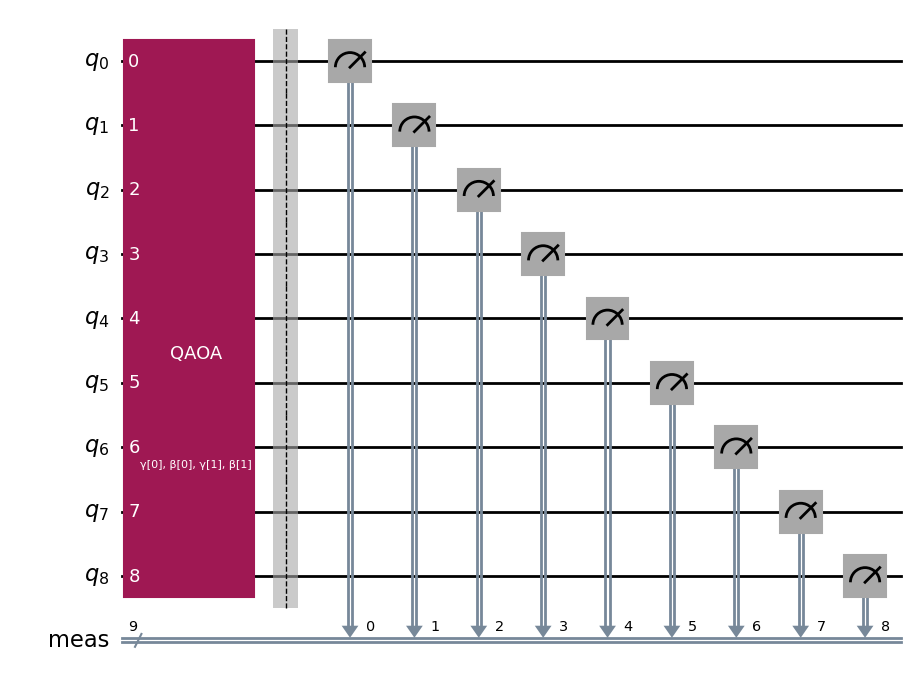

In [35]:
ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
ansatz.measure_all()
ansatz.draw("mpl")

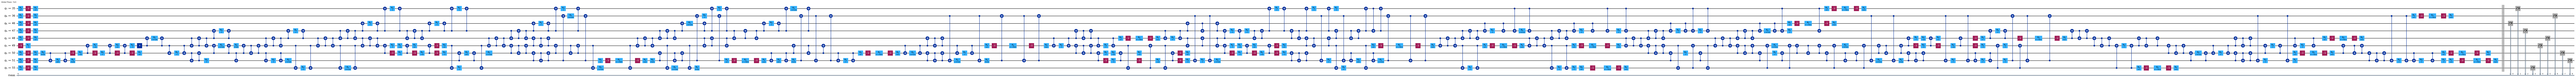

In [37]:
backend = FakeWashingtonV2()


 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(ansatz)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [38]:
init_params = np.random.rand(ansatz.num_parameters) * 2 * np.pi

In [39]:
objective_func_vals = []  # Global variable

In [40]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [41]:

with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.6403596403596404
       x: [ 6.400e+00  1.219e+00  5.189e+00  5.789e+00]
    nfev: 22
   maxcv: 0.0


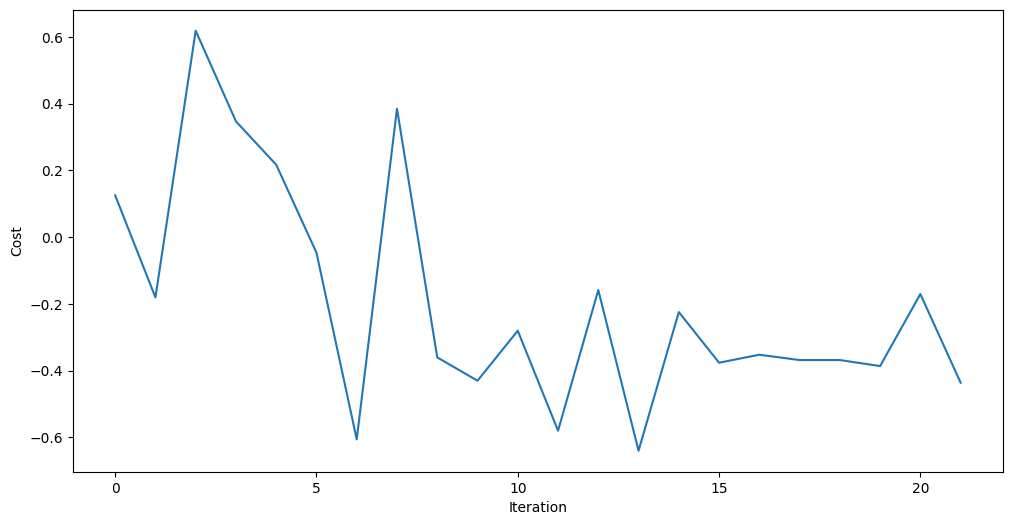

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

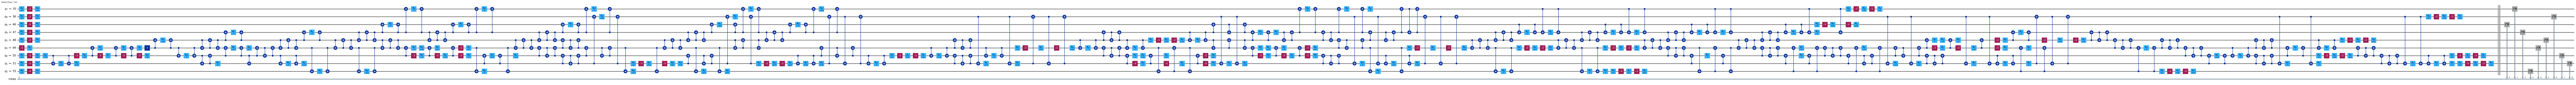

In [44]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [45]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"
 
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{383: 0.0044, 233: 0.0021, 495: 0.0043, 126: 0.002, 272: 0.0014, 139: 0.0016, 361: 0.0019, 345: 0.0022, 286: 0.0013, 269: 0.002, 376: 0.0028, 374: 0.0027, 353: 0.0018, 437: 0.0023, 254: 0.0037, 160: 0.0008, 27: 0.002, 49: 0.0019, 332: 0.0013, 225: 0.0023, 455: 0.0025, 487: 0.004, 334: 0.0016, 402: 0.0011, 377: 0.0024, 507: 0.0055, 369: 0.002, 217: 0.0022, 147: 0.0016, 315: 0.0027, 228: 0.0025, 222: 0.0021, 382: 0.003, 322: 0.0018, 88: 0.0014, 488: 0.0033, 214: 0.0018, 253: 0.0036, 346: 0.0017, 318: 0.0034, 491: 0.0049, 75: 0.001, 143: 0.0021, 413: 0.0022, 140: 0.0014, 435: 0.0018, 381: 0.0033, 158: 0.0016, 326: 0.0013, 451: 0.0031, 317: 0.0026, 30: 0.0022, 450: 0.0029, 180: 0.0021, 184: 0.002, 373: 0.0025, 474: 0.0021, 359: 0.0021, 220: 0.0011, 104: 0.0018, 209: 0.0016, 172: 0.0018, 302: 0.0012, 358: 0.002, 471: 0.0028, 378: 0.0035, 417: 0.0014, 367: 0.0032, 500: 0.0025, 165: 0.0028, 87: 0.0033, 255: 0.0067, 466: 0.0019, 224: 0.0021, 347: 0.0015, 311: 0.0018, 508: 0.0029, 380: 0.003, 1

In [47]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(data['syms']))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 1, 1, 1, 1, 1, 1, 0]


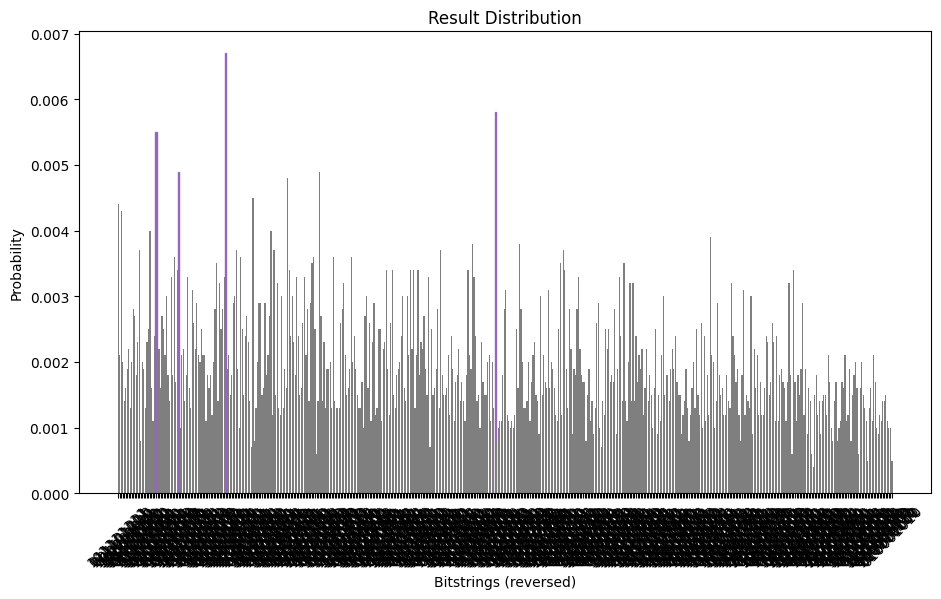

In [48]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()